Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   
___
## Otimização da disposição de alvenaria em pórtico 2D

*Daniel B. M. Matos (PPGEC/UFRGS)*

*Letícia Fleck Fadel Miguel (PPGEC/UFGRS)*
___
#### 1 Introdução
#### 2 Modelagem matemática da estrutura
#### 3 Aplicação de um sismo artificial
#### 3.1 Otimização da disposição da alvenaria
#### 3.2 Comparação dos resultados com e sem alvenaria
#### 4 Aplicação de um sismo real
#### 4.1 Otimização da disposição da alvenaria
#### 4.2 Comparação dos resultados com e sem alvenaria
#### 5 Análise por espectros de reposta
___


### 1 Introdução
Este *Notebook* tem como finalidade avaliar a otimização da disposição de paredes de vedação no intuito de minimizar o *storydrift* em um pórtico de concreto armado. A estrutura em análise está exposta na Figura abaixo.

![Portico](Resources/Portico1.PNG)



### 2 Modelagem matemática da estrutura
Primeiramente, importam-se os módulos necessários.

In [1]:
import Wall as wl                          # Módulo criado para a utilização das paredes.
from Wall import Vibmec as vib             # Classe para utilização de funções dinâmicas.
import numpy as np
import matplotlib.pyplot as plt
from pso import pso_simple                 # Módulo destinado a otimização por PSO.
from time import time
import scipy
from scipy import signal

Agora, cria-se um objeto ```Vibmec``` para a realização dos procedimentos dinâmicos.

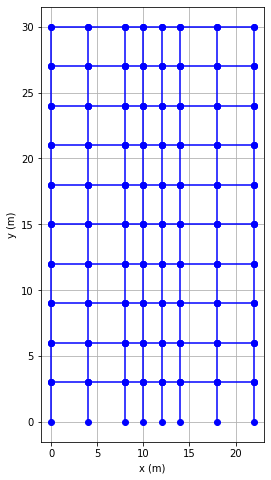

In [2]:
E = np.ones(150)*28*10**9
Port = vib('Resources/ARQUIVO_BASE.xlsx',88,E)
Port.DRAW()

Utilizando os atributos da classe, é possível restringir os graus de liberdade da base, calcular os autovalores e autovetores e definir a matriz de amortecimento do objeto.

In [3]:
Port.Restr(np.arange(24))
Port.Eig(3)
Port.Rayleigh(0.05,0.05)

1 ª frequencia natural = 2.76Hz 

2 ª frequencia natural = 7.29Hz 

3 ª frequencia natural = 13.70Hz 



### 3 Aplicação de um sismo artificial
Tendo o sistema modelado matematicamente, define-se o vetor de cargas com o auxílio do método de Shinouzuka e Jan, tendo como entrada o espectro de Kanai e Tajimi.

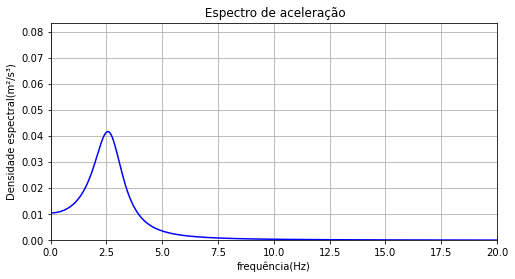

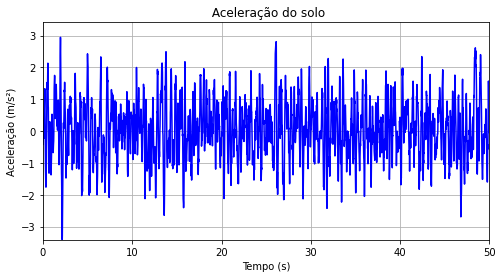

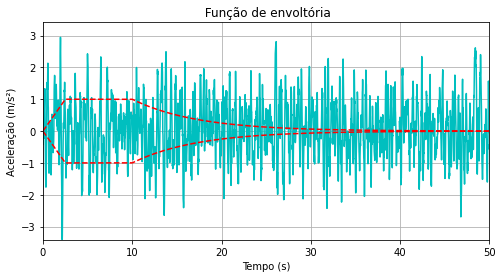

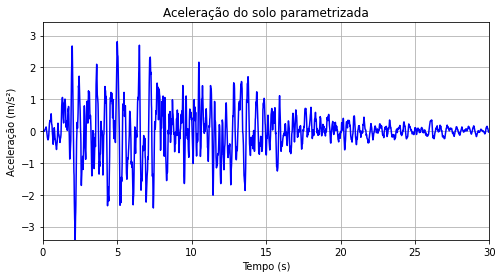

In [4]:
Port.SeismicAceleration(0.348,'rocha',50,0.01,2.76)
age = Port.Envolve()
F   = Port.Sismo(age)
d,v,a = Port.Newmark(F,np.zeros(240),np.zeros(240),Port.time)

Afim de conferir a a frequência que concentra a maior energia no sistema, confecciona-se um periodograma

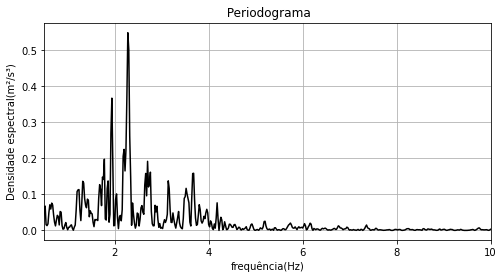

In [5]:
plt.figure(16,figsize=(8,4))
f,Saz = scipy.signal.periodogram(age,(len(age)/np.max(Port.time)))
plt.plot(f,Saz,'k')
plt.xlabel('frequência(Hz)'); plt.ylabel('Densidade espectral(m²/s³)');
plt.xlim(0.5,10); plt.title(' Periodograma')
plt.grid(True)

#### 3.1 Otimização da disposição da alvenaria
Tendo em posse os valores de deslocamentos e de *Storydrifts*, inicia-se o processo de otimização estrutural. Para isso, utiliza-se o método *Particle Swarm Otimization* (PSO) para encontrar o pavimento em que a consideração da alvenaria de vedação como sistema de contraventamento minimiza o *Storydrift* do edifício.

In [6]:
# Definição da função objetivo
def func1(x):
    
    Port.Wall(88,x,np.arange(24),6*10**-3)
    d1,v1,a1 = Port.Newmark(F,np.zeros(240),np.zeros(240),Port.time,Wall = True)
    sdmax1 = vib.Storydrift(d1)
    
    return np.max(sdmax1)

iter:    0, Melhor solução: -1.00000000, Andar: []
iter:    1, Melhor solução: 0.00520119, Andar: [4]
iter:    2, Melhor solução: 0.00498253, Andar: [3]
iter:    3, Melhor solução: 0.00478812, Andar: [2]
iter:    4, Melhor solução: 0.00441726, Andar: [1]
iter:    5, Melhor solução: 0.00441726, Andar: [1]
iter:    6, Melhor solução: 0.00441726, Andar: [1]
iter:    7, Melhor solução: 0.00441726, Andar: [1]
iter:    8, Melhor solução: 0.00441726, Andar: [1]
iter:    9, Melhor solução: 0.00441726, Andar: [1]

Solução final:
   > [1]
   > 0.004417259608531343

O tempo de processamento foi de 69.30 segundos


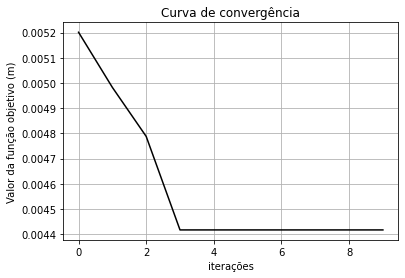

In [7]:
initial = [4]           # Valor inicial
bounds  = [(0,9)]       # Valores limite
t1 = time()
e,p,i = pso_simple.minimize(func1, initial, bounds, num_particles=10, maxiter=10, verbose=True)
t2 = time()
print('O tempo de processamento foi de {:.2f} segundos'.format(t2-t1))

plt.plot(i,p,'k')
plt.title('Curva de convergência')
plt.xlabel('iterações')
plt.ylabel('Valor da função objetivo (m)')
plt.grid(True)


### 3.1 Comparação dos resultados
Após o processo de otmização, tendo em posse o pavimento em que a alvenaria minimiza o *Storydrift* do edifício, é possível plotar a comparação entre as duas simulações em termos de deslocamentos no último pavimento e máximo *storydrif* por andar.

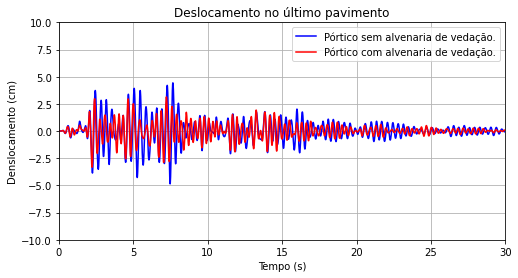

In [8]:
Port.Wall(88,e[-1],np.arange(24),6*10**-3)
d1,v1,a1 = Port.Newmark(F,np.zeros(240),np.zeros(240),Port.time,Wall = True)
sdmax1 = vib.Storydrift(d1)


plt.figure(10,figsize=(8,4))
plt.plot(Port.time,d[237,:]*100,'b',label = 'Pórtico sem alvenaria de vedação.')
plt.plot(Port.time,d1[237,:]*100,'r',label = 'Pórtico com alvenaria de vedação.')
plt.xlabel('Tempo (s)'); plt.ylabel('Denslocamento (cm)');
plt.xlim(0,30); plt.ylim(-10,10); plt.title('Deslocamento no último pavimento')
plt.legend()
plt.grid(True)

sdmax = vib.Storydrift(d)
andar = np.arange(11)

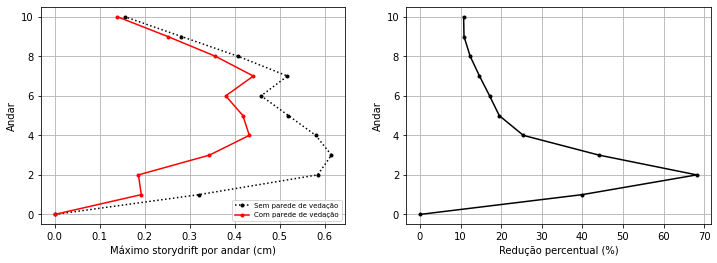

In [9]:
plt.figure(3,figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(sdmax*100,andar,'k:.',label='Sem parede de vedação')
plt.plot(sdmax1*100,andar,'r.-',label = 'Com parede de vedação')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend(loc='lower right',fontsize='x-small')
plt.grid(True)

r = np.zeros(len(sdmax))
r[1:] = (sdmax[1:]-sdmax1[1:])/sdmax[1:]*100
plt.subplot(1,2,2)
plt.plot(r,andar,'k.-')
plt.xlabel('Redução percentual (%)')
plt.ylabel('Andar')
plt.grid(True)


### 4. Aplicação de um carregamento real

Repete-se o mesmo procedimento a cima utilizando um carregamento real

<Figure size 432x288 with 0 Axes>

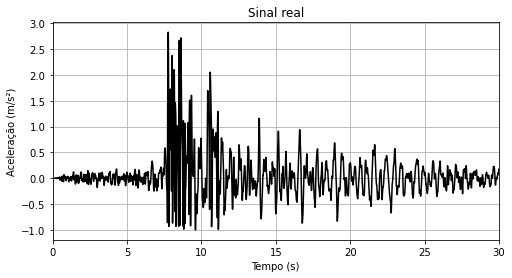

In [10]:
Port.SeismicAceleration(0.348,'rocha',50,0.01,2.76,'Resources/Sismo_real.txt')
plt.xlim(0,10)
#age = Port.Envolve()
ag = Port.signal*100
F   = Port.Sismo(ag)
plt.clf()
d2,v2,a2 = Port.Newmark(F,np.zeros(240),np.zeros(240),Port.time)
plt.figure(1000,figsize=(8,4))

plt.plot(Port.time-30,ag,'k')
plt.title('Sinal real')
plt.xlabel('Tempo (s)')
plt.xlim(0,30)
plt.ylabel('Aceleração (m/s²)')
plt.grid(True)

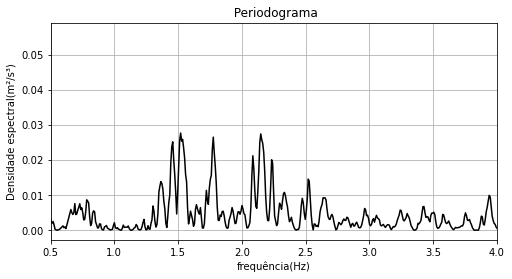

In [11]:
plt.figure(16,figsize=(8,4))
f,Saz = scipy.signal.periodogram(ag,(len(ag)/np.max(Port.time)))
plt.plot(f,Saz,'k')
plt.xlabel('frequência(Hz)'); plt.ylabel('Densidade espectral(m²/s³)');
plt.xlim(0.5,4); plt.title(' Periodograma')
plt.grid(True)

iter:    0, Melhor solução: -1.00000000, Andar: []
iter:    1, Melhor solução: 0.00236981, Andar: [5]
iter:    2, Melhor solução: 0.00225166, Andar: [4]
iter:    3, Melhor solução: 0.00207734, Andar: [3]
iter:    4, Melhor solução: 0.00194006, Andar: [2]
iter:    5, Melhor solução: 0.00194006, Andar: [2]
iter:    6, Melhor solução: 0.00194006, Andar: [2]
iter:    7, Melhor solução: 0.00194006, Andar: [2]
iter:    8, Melhor solução: 0.00194006, Andar: [2]
iter:    9, Melhor solução: 0.00194006, Andar: [2]

Solução final:
   > [2]
   > 0.0019400582521398643

O tempo de processamento foi de 198.86 segundos


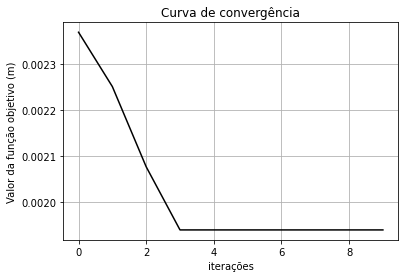

In [12]:
initial = [5]           # Valor inicial
bounds  = [(0,9)]       # Valores limite
t1 = time()
e,p,i = pso_simple.minimize(func1, initial, bounds, num_particles=10, maxiter=10, verbose=True)
t2 = time()
print('O tempo de processamento foi de {:.2f} segundos'.format(t2-t1))

plt.plot(i,p,'k')
plt.title('Curva de convergência')
plt.xlabel('iterações')
plt.ylabel('Valor da função objetivo (m)')
plt.grid(True)

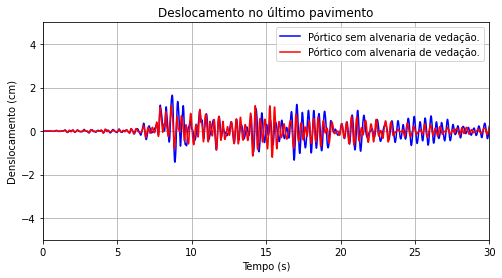

In [13]:
Port.Wall(88,e[-1],np.arange(24),6*10**-3)
d3,v3,a3 = Port.Newmark(F,np.zeros(240),np.zeros(240),Port.time,Wall = True)
sdmax3 = vib.Storydrift(d3)


plt.figure(10,figsize=(8,4))
plt.plot(Port.time-30,d2[237,:]*100,'b',label = 'Pórtico sem alvenaria de vedação.')
plt.plot(Port.time-30,d3[237,:]*100,'r',label = 'Pórtico com alvenaria de vedação.')
plt.xlabel('Tempo (s)'); plt.ylabel('Denslocamento (cm)');
plt.xlim(0,30); plt.ylim(-5,5); plt.title('Deslocamento no último pavimento')
plt.legend()
plt.grid(True)

sdmax2 = vib.Storydrift(d2)
andar = np.arange(11)

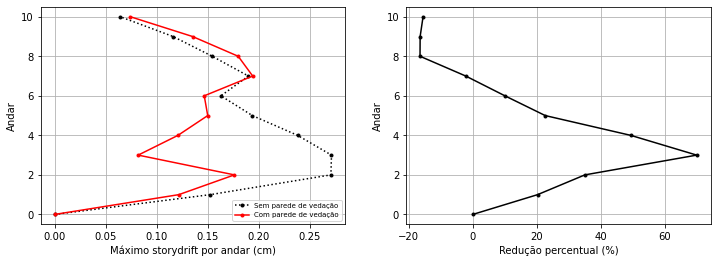

In [14]:
plt.figure(5,figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(sdmax2*100,andar,'k:.',label='Sem parede de vedação')
plt.plot(sdmax3*100,andar,'r.-',label = 'Com parede de vedação')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend(loc='lower right',fontsize='x-small')
plt.grid(True)

r2 = np.zeros(len(sdmax2))
r2[1:] = (sdmax2[1:]-sdmax3[1:])/sdmax2[1:]*100
plt.subplot(1,2,2)
plt.plot(r2,andar,'k.-')
plt.xlabel('Redução percentual (%)')
plt.ylabel('Andar')
plt.grid(True)

## 5. Análise no domínio da frequência a partir do espectro de resposta

Realiza-se agora uma análise modal a partir do espectro de pseudoaceleração confeccionado a partir do sinal utilizado na análise no domínio do tempo 

In [15]:
import Pseudo 
def Pseudoacel(ag1,trace):
    wn =np.linspace(100,0.1,1000)
    u  = Pseudo.Duhamel(wn,ag1,Port.time[:5000])
    umax = np.zeros(len(wn))
    for i in range(len(wn)):
        umax[i] = np.amax(u[i,:])
    plt.figure(3,figsize=(12,4))
    ap = wn**2*umax
    plt.xscale('log')
    plt.plot(2*np.pi/wn,ap,trace)
    plt.title('Espectro de pseudoacelerações')
    plt.xlabel('Período de oscilação(s)');plt.ylabel('Aceleração(m/s²)')
    #plt.xlim(0,3)
    #plt.ylim(0,0.02)
    plt.grid(True)
    
    return wn,ap

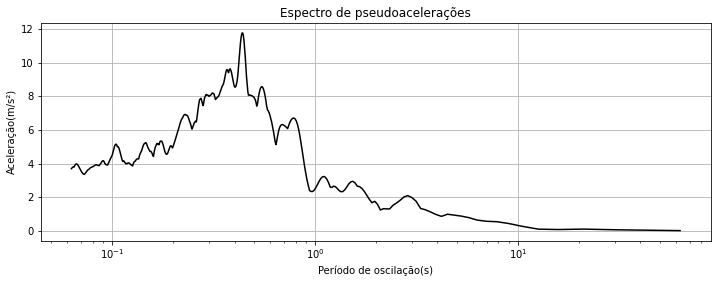

In [16]:
wn,ap = Pseudoacel(age,'k')

In [17]:
nm = 5
Port.Modal_Analysis(F,np.zeros(240),np.zeros(240),nm)

In [18]:
Fmax_p = Port.FreqDomain(ap,2*np.pi/wn)

Número de modos necessários = 2 Wi =  91.03797063623126 %


In [19]:
umax_1p = np.linalg.inv(Port.RestK)@Fmax_p
SQRSS_P = np.sqrt(np.sum(umax_1p**2,1))
print('O deslocamento máximo no domínio da frequência é:',np.max(SQRSS_P)*100,'cm')
print('O deslocamento máximo no domínio do tempo é:',np.amax(d)*100,'cm')
print('Erro percentual:',abs(np.amax(d)-np.max(SQRSS_P))/np.amax(d)*100,'%')

O deslocamento máximo no domínio da frequência é: 4.459090752340329 cm
O deslocamento máximo no domínio do tempo é: 4.433338030827573 cm
Erro percentual: 0.5808878396748134 %


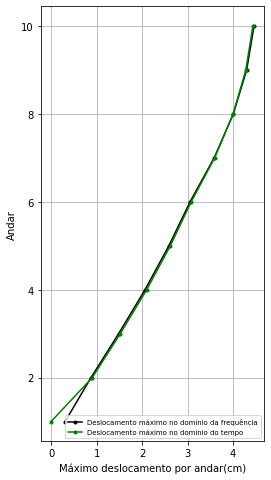

In [20]:
plt.figure(12,figsize=(4,8))
plt.plot(SQRSS_P[::24]*100,andar[1:],'k.-',label = 'Deslocamento máximo no domínio da frequência')
plt.xlabel('Máximo deslocamento por andar(cm)')
plt.ylabel('Andar')
plt.grid(True)

hd    = d[::24,:]
umax = np.zeros(len(hd[:]))

for i in range(1,len(hd[:])):
            
        umax[i] = np.amax(hd[i,:])
plt.plot(umax*100,andar[1:],'g.-',label = 'Deslocamento máximo no domínio do tempo')
plt.legend(loc='lower right',fontsize='x-small')

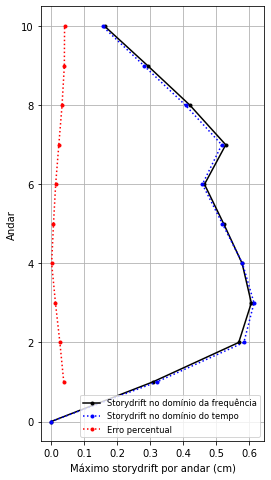

In [21]:
hd    = SQRSS_P[::24]
sd    = np.zeros(hd.shape)
sdmax_f = np.zeros(len(hd[:])+1)
        
sd[0] = hd[0]
for i in range(1,len(hd[:])):
            
        sd[i] = hd[i] - hd[i-1]
        
for i in  range(1,len(hd[:])+1):
            
        sdmax_f[i] = np.max(sd[i-1])

plt.figure(12,figsize=(4,8))
plt.plot(sdmax_f*100,andar,'k.-',label='Storydrift no domínio da frequência')
plt.plot(sdmax*100,andar,'b:.',label='Storydrift no domínio do tempo')
plt.plot(abs(sdmax[1:]-sdmax_f[1:])/sdmax[1:],andar[1:],'r:.',label='Erro percentual')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend()
plt.legend(loc='lower right',fontsize='small')
plt.grid(True)

### 5.1 Otimização pelo método do espectro de resposta

In [22]:
def func2(x):
    Port.Wall(88,x,np.arange(24),6*10**-3)
    Port.Eig(3,Wall = True,Verbose = False)
    
    Fmax_p = Port.FreqDomain(ap,2*np.pi/wn,Verbose = False)
    umax_1p = np.linalg.inv(Port.W)@Fmax_p
    
    SQRSS_P = np.sqrt(np.sum(umax_1p**2,1))
    
    hd    = SQRSS_P[::24]
    sd    = np.zeros(hd.shape)
    sdmax_f = np.zeros(len(hd[:])+1)
        
    sd[0] = hd[0]
    for i in range(1,len(hd[:])):
            
        sd[i] = hd[i] - hd[i-1]
        
    for i in  range(1,len(hd[:])+1):
            
        sdmax_f[i] = np.max(sd[i-1])
        
    return np.amax(sdmax_f)
    

iter:    0, Melhor solução: -1.00000000, Andar: []
iter:    1, Melhor solução: 0.00507539, Andar: [4]
iter:    2, Melhor solução: 0.00454786, Andar: [3]
iter:    3, Melhor solução: 0.00452405, Andar: [2]
iter:    4, Melhor solução: 0.00436748, Andar: [1]
iter:    5, Melhor solução: 0.00436748, Andar: [1]
iter:    6, Melhor solução: 0.00436748, Andar: [1]
iter:    7, Melhor solução: 0.00436748, Andar: [1]
iter:    8, Melhor solução: 0.00436748, Andar: [1]
iter:    9, Melhor solução: 0.00436748, Andar: [1]

Solução final:
   > [1]
   > 0.004367478036507267

O tempo de processamento foi de 20.65 segundos


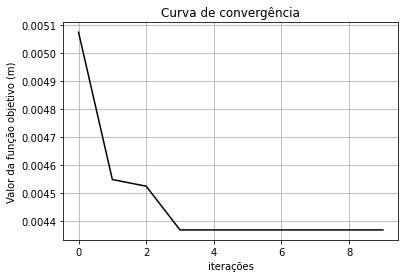

In [23]:
initial = [4]           # Valor inicial
bounds  = [(0,9)]       # Valores limite
t1 = time()

e3,p3,i3 = pso_simple.minimize(func2, initial, bounds, num_particles=15, maxiter=10, verbose=True)
t2 = time()
print('O tempo de processamento foi de {:.2f} segundos'.format(t2-t1))

plt.plot(i3,p3,'k')
plt.title('Curva de convergência')
plt.xlabel('iterações')
plt.ylabel('Valor da função objetivo (m)')
plt.grid(True)

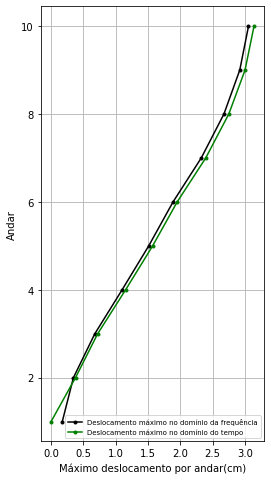

In [30]:
Port.Wall(88,e3[-1],np.arange(24),6*10**-3)
Port.Eig(3,Wall = True,Verbose = False) 
Fmax_p = Port.FreqDomain(ap,2*np.pi/wn,Verbose = False)
umax_2p = np.linalg.inv(Port.W)@Fmax_p
    
SQRSS_P2 = np.sqrt(np.sum(umax_2p**2,1))

plt.figure(12,figsize=(4,8))
plt.plot(SQRSS_P2[::24]*100,andar[1:],'k.-',label = 'Deslocamento máximo no domínio da frequência')
plt.xlabel('Máximo deslocamento por andar(cm)')
plt.ylabel('Andar')
plt.grid(True)

hd2    = d1[::24]
umax2 = np.zeros(len(hd2[:]))

for i in range(1,len(hd2[:])):
            
        umax2[i] = np.amax(hd2[i])
        
plt.plot(umax2*100,andar[1:],'g.-',label = 'Deslocamento máximo no domínio do tempo')
plt.legend(loc='lower right',fontsize='x-small')

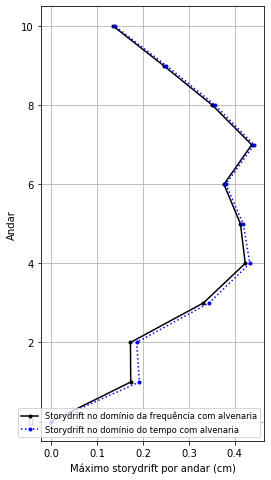

In [31]:

Fmax_p = Port.FreqDomain(ap,2*np.pi/wn,Verbose = False)
umax_2p = np.linalg.inv(Port.W)@Fmax_p
    
SQRSS_P2 = np.sqrt(np.sum(umax_2p**2,1))
    
hd2    = SQRSS_P2[::24]
sd2    = np.zeros(hd2.shape)
sdmax_f2 = np.zeros(len(hd2[:])+1)
        
sd2[0] = hd2[0]
for i in range(1,len(hd2[:])):
            
    sd2[i] = hd2[i] - hd2[i-1]
        
for i in  range(1,len(hd2[:])+1):
            
    sdmax_f2[i] = np.max(sd2[i-1])


plt.figure(12,figsize=(4,8))
plt.plot(sdmax_f2*100,andar,'k.-',label='Storydrift no domínio da frequência com alvenaria')
plt.plot(sdmax1*100,andar,'b:.',label='Storydrift no domínio do tempo com alvenaria')
#plt.plot(abs(sdmax1[1:]-sdmax_f2[1:])/sdmax1[1:],andar[1:],'r:.',label='Erro percentual')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend()
plt.legend(loc='lower right',fontsize='small')
plt.grid(True)
        

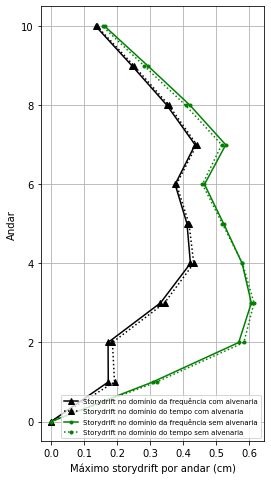

In [44]:
plt.figure(12,figsize=(4,8))
plt.plot(sdmax_f2*100,andar,'k^-',label='Storydrift no domínio da frequência com alvenaria')
plt.plot(sdmax1*100,andar,'k^:',label='Storydrift no domínio do tempo com alvenaria')
plt.plot(sdmax_f*100,andar,'g.-',label='Storydrift no domínio da frequência sem alvenaria')
plt.plot(sdmax*100,andar,'g:.',label='Storydrift no domínio do tempo sem alvenaria')
#plt.plot(abs(sdmax1[1:]-sdmax_f2[1:])/sdmax1[1:],andar[1:],'r:.',label='Erro percentual')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend()
plt.legend(loc='lower right',fontsize='x-small')
plt.grid(True)